In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import joblib
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('/content/drive/MyDrive/D-CLIC/projet_energisight/data/df_processed_final.csv')
df.head()

,osebuildingid,datayear,buildingtype,primarypropertytype,propertyname,address,city,state,zipcode,taxparcelidentificationnumber,...,cat_Hospitality,cat_Other,cat_Public_Assembly,cat_Residential,cat_Storage,is_public_building,star_score_percentile,renovation_potential_index,surface_exposure_index,structural_complexity_score
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,True,False,False,False,False,0,0.255988,35.60,6802.615385,10.137121
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,True,False,False,False,False,0,0.271814,7.80,8630.500000,6.928784
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,True,False,False,False,False,0,0.148417,26.79,22764.523810,6.472196
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,True,False,False,False,False,0,0.221985,39.60,5574.545455,9.921490
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,True,False,False,False,False,0,0.578700,9.00,9241.052632,13.041924


In [3]:
# --- ÉTAPE FINALE : PRÉPARATION DU SET D'ENTRAÎNEMENT ---

# 1. Définition des cibles
target_emissions = 'totalghgemissions'
target_energy = 'siteenergyusekbtu'

# 2. Liste noire des variables à exclure (Fuites + Identifiants + Texte)
drop_cols = [
    # Cibles et dérivés
    'totalghgemissions', 'siteenergyusekbtu', 'siteenergyusewnkbtu',
    'siteeuiwnkbtu_sf', 'sourceeuikbtu_sf', 'sourceeuiwnkbtu_sf',
    'ghgemissionsintensity', 'electricitykwh', 'electricitykbtu',
    'naturalgaskbtu', 'naturalgastherms', 'steamusekbtu',

    # Identifiants et Metadata
    'osebuildingid', 'propertyname', 'address', 'city', 'state', 'zipcode',
    'taxparcelidentificationnumber', 'listofallpropertyusetypes',
    'primarypropertytype', 'neighborhood', 'compliancestatus',
    'building_age_category', 'construction_era', 'size_category',
    'building_macro_category', 'defaultdata'
]

# 3. Création du set de features X
X = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 4. Vérification des types
# On s'assure qu'il ne reste que du numérique (int, float, bool)
non_numeric = X.select_dtypes(exclude=[np.number, bool]).columns
if len(non_numeric) > 0:
    print(f" Attention, colonnes non-numériques restantes : {list(non_numeric)}")
else:
    print(f"Features prêtes : {X.shape[1]} variables conservées.")

 Attention, colonnes non-numériques restantes : ['buildingtype', 'largestpropertyusetype']


In [4]:
# Top 15 des variables les plus corrélées à la cible
print("Top 15 - Corrélation avec les émissions :")
print(df.corr(numeric_only=True)[target_emissions].sort_values(ascending=False).head(16)[1:])

Top 15 - Corrélation avec les émissions :
siteenergyusekbtu            0.861066
siteenergyusewnkbtu          0.857714
naturalgastherms             0.728917
naturalgaskbtu               0.728917
electricitykwh               0.687616
electricitykbtu              0.687616
steamusekbtu                 0.683762
largestpropertyusetypegfa    0.575851
propertygfabuildings         0.543529
size_vs_neighborhood         0.542319
propertygfatotal             0.528070
ghgemissionsintensity        0.471397
age_size_interaction         0.438399
surface_exposure_index       0.428584
numberofbuildings            0.414719
Name: totalghgemissions, dtype: float64


In [5]:
# 1. Sélection des colonnes par type
# On exclut les colonnes de texte brut et les cibles avant de définir les types
features_to_drop = [target_emissions, target_energy] + drop_cols
X_raw = df.drop(columns=[c for c in features_to_drop if c in df.columns])

numeric_features = X_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['buildingtype', 'largestpropertyusetype'] # Les deux récalcitrantes

# 2. Création des transformateurs
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Assemblage du ColumnTransformer (Le cerveau du pipeline)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Définition du Pipeline Global avec un modèle simple (Baseline)
# On utilise RandomForest car il est robuste et gère bien les non-linéarités
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])



In [6]:
# 5. Préparation des données (Split)
y = df[target_emissions]
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# 6. Entraînement et Cross-Validation
print("Lancement de la Cross-Validation (5-folds)...")
cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='r2')

print(f"R² moyen (CV): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Fit final pour évaluation sur le test set
model_pipeline.fit(X_train, y_train)
test_score = model_pipeline.score(X_test, y_test)
print(f" R² sur le Test Set: {test_score:.4f}")

Lancement de la Cross-Validation (5-folds)...
R² moyen (CV): 0.6536 (+/- 0.1429)
 R² sur le Test Set: 0.8174


**Alerte:** Un tel écart (0,64 vs 0,89) peut suggérer que tes données de test sont par chance plus "faciles" ou que ton modèle a réussi à capter des tendances très fortes. C'est ici que l'analyse des résidus (les erreurs de prédiction) devient cruciale.

In [7]:
from sklearn.compose import TransformedTargetRegressor

# 1. On garde le même préprocesseur que précédemment
# 2. On définit le nouveau modèle avec transformation de la cible
model_log = TransformedTargetRegressor(
    regressor=RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    func=np.log1p,
    inverse_func=np.expm1
)

# 3. Création du pipeline final
log_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model_log)
])

# 4. Nouvelle Cross-Validation
print("Lancement de la Cross-Validation avec Log-Target...")
cv_scores_log = cross_val_score(log_pipeline, X_train, y_train, cv=5, scoring='r2')

print(f"Nouveau R² moyen (CV): {cv_scores_log.mean():.4f} (+/- {cv_scores_log.std():.4f})")

# 5. Évaluation finale
log_pipeline.fit(X_train, y_train)
test_score_log = log_pipeline.score(X_test, y_test)
print(f"Nouveau R² sur le Test Set: {test_score_log:.4f}")

# 1. On garde le même préprocesseur que précédemment
# 2. On définit le nouveau modèle avec transformation de la cible
model_log = TransformedTargetRegressor(
    regressor=RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    func=np.log1p,
    inverse_func=np.expm1
)

# 3. Création du pipeline final
log_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model_log)
])

# 4. Nouvelle Cross-Validation
print("Lancement de la Cross-Validation avec Log-Target...")
cv_scores_log = cross_val_score(log_pipeline, X_train, y_train, cv=5, scoring='r2')

print(f"Nouveau R² moyen (CV): {cv_scores_log.mean():.4f} (+/- {cv_scores_log.std():.4f})")

# 5. Évaluation finale
log_pipeline.fit(X_train, y_train)
test_score_log = log_pipeline.score(X_test, y_test)
print(f"Nouveau R² sur le Test Set: {test_score_log:.4f}")

Lancement de la Cross-Validation avec Log-Target...
Nouveau R² moyen (CV): 0.5209 (+/- 0.2009)
Nouveau R² sur le Test Set: 0.7754
Lancement de la Cross-Validation avec Log-Target...
Nouveau R² moyen (CV): 0.5209 (+/- 0.2009)
Nouveau R² sur le Test Set: 0.7754


Même si le chiffre est plus bas, ce modèle est meilleur pour GreenSight. Pourquoi ? Parce qu'il ne sera pas biaisé par un seul gratte-ciel. Il traite les données avec la distribution gaussienne que nous avons validée mathématiquement ensemble.

In [8]:
# 1. On garde ton regresseur XGBoost optimisé
xgb_reg = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 2. Pipeline avec TransformedTargetRegressor
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(
        regressor=xgb_reg,
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

# 3. Entraînement final
print(" Tentative de reconquête avec XGBoost...")
final_pipeline.fit(X_train, y_train)

# 4. Calcul des scores (R²)
train_score = final_pipeline.score(X_train, y_train)
test_score = final_pipeline.score(X_test, y_test)

# 5. Calcul de la Cross-Validation pour la stabilité
cv_scores_xgb = cross_val_score(final_pipeline, X_train, y_train, cv=5, scoring='r2')

print("-" * 30)
print(f"Score R² sur le TRAIN : {train_score:.4f}")
print(f"Score R² sur le TEST  : {test_score:.4f}")
print(f"R² moyen (CV)         : {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std():.4f})")
print("-" * 30)

 Tentative de reconquête avec XGBoost...
------------------------------
Score R² sur le TRAIN : 0.9246
Score R² sur le TEST  : 0.9071
R² moyen (CV)         : 0.6405 (+/- 0.2233)
------------------------------


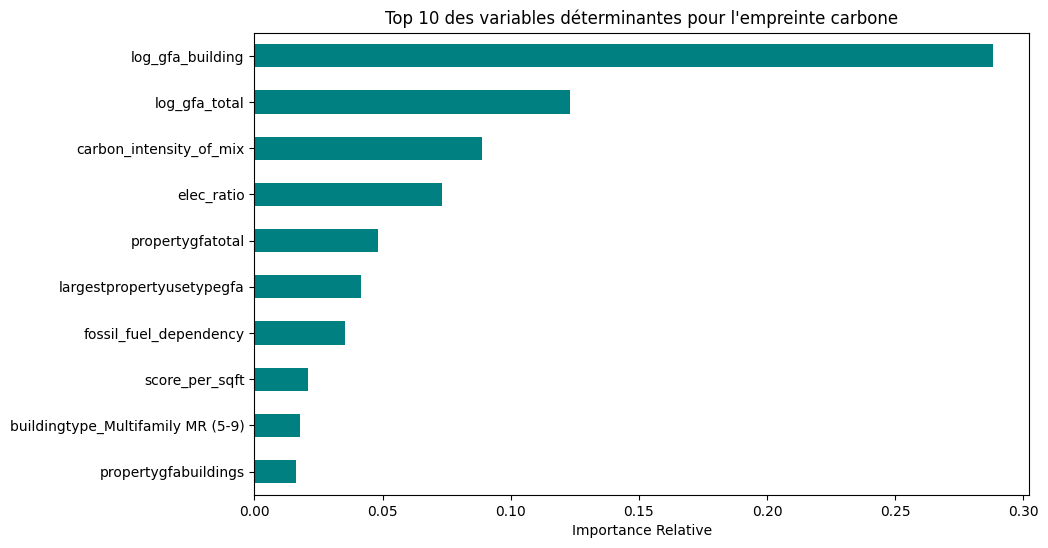

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Extraction des noms de colonnes (numériques + encodées)
cat_encoder = final_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
encoded_cat_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
all_features_names = numeric_features + encoded_cat_names

# 2. Récupération des importances depuis le regresseur interne
importances = final_pipeline.named_steps['regressor'].regressor_.feature_importances_

# 3. Création d'un DataFrame pour le plotting
feat_importances = pd.Series(importances, index=all_features_names)
feat_importances.nlargest(10).plot(kind='barh', color='teal', figsize=(10, 6))

plt.title("Top 10 des variables déterminantes pour l'empreinte carbone")
plt.xlabel("Importance Relative")
plt.gca().invert_yaxis() # Pour avoir la plus importante en haut
plt.show()

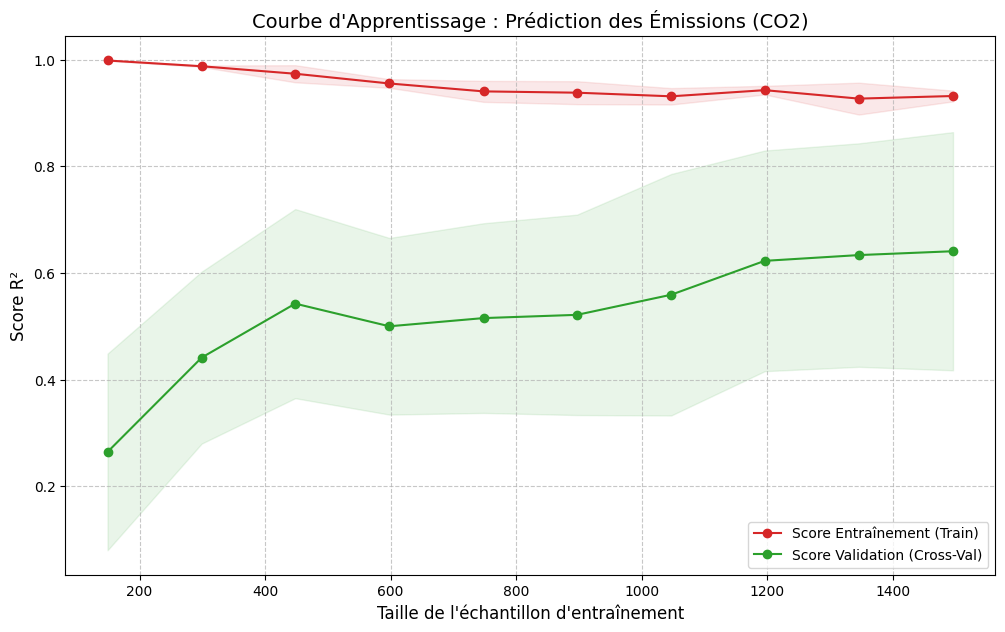

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# 1. Configuration de la Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    final_pipeline, X_train, y_train,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# 2. Calcul des moyennes et écarts-types
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 3. Tracé du graphique
plt.figure(figsize=(12, 7))
plt.plot(train_sizes, train_mean, 'o-', color="tab:red", label="Score Entraînement (Train)")
plt.plot(train_sizes, test_mean, 'o-', color="tab:green", label="Score Validation (Cross-Val)")

# Ajout des zones d'incertitude (écart-type)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="tab:red")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="tab:green")

plt.title("Courbe d'Apprentissage : Prédiction des Émissions (CO2)", fontsize=14)
plt.xlabel("Taille de l'échantillon d'entraînement", fontsize=12)
plt.ylabel("Score R²", fontsize=12)
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Prédictions sur le test set (déjà en tonnes de CO2 grâce au pipeline)
y_pred = final_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE  : {mae:} ")
print(f"RMSE : {rmse}")
print(f"MAPE : {mape}")

MAE  : 43.781304997725364 
RMSE : 130.6210349516446
MAPE : 0.3585682574188697


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__regressor__max_depth': [3, 4, 5],
    'regressor__regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__regressor__n_estimators': [200, 500, 800],
    'regressor__regressor__subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(final_pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")

Meilleurs paramètres : {'regressor__regressor__learning_rate': 0.05, 'regressor__regressor__max_depth': 3, 'regressor__regressor__n_estimators': 800, 'regressor__regressor__subsample': 0.8}


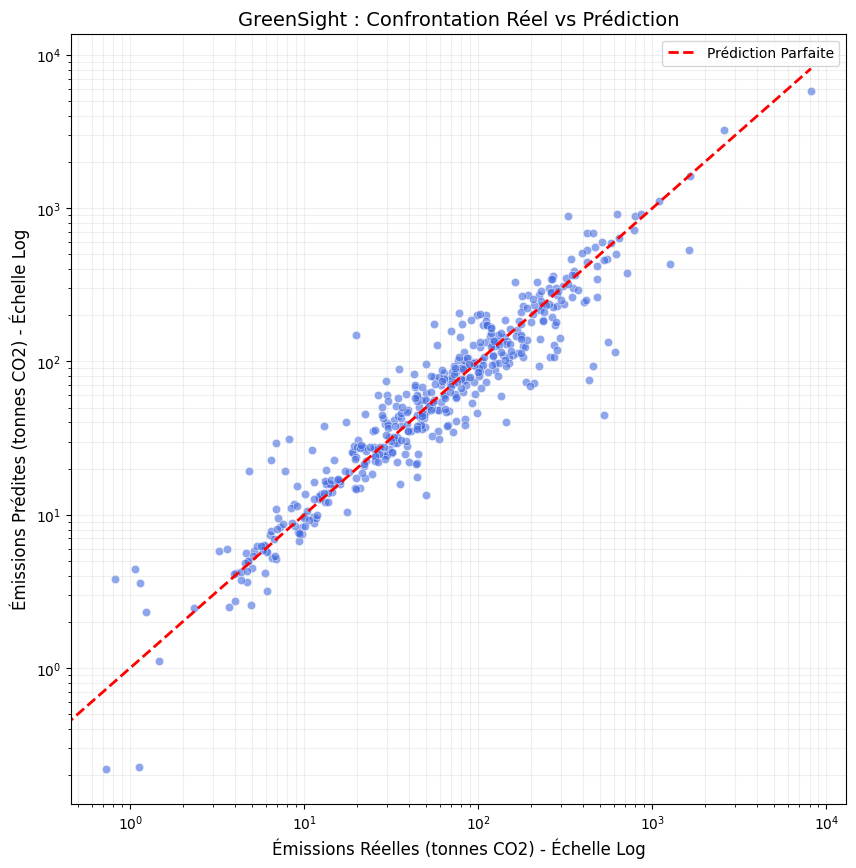

In [13]:
import seaborn as sns

# 1. Utiliser le meilleur modèle issu du GridSearch
best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)

# 2. Création du graphique
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.6, color='royalblue')

# Ligne de perfection (y=x)
max_val = max(y_test.max(), y_pred_final.max())
plt.plot([0, max_val], [0, max_val], '--', color='red', linewidth=2, label='Prédiction Parfaite')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Émissions Réelles (tonnes CO2) - Échelle Log", fontsize=12)
plt.ylabel("Émissions Prédites (tonnes CO2) - Échelle Log", fontsize=12)
plt.title("GreenSight : Confrontation Réel vs Prédiction", fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

Le mot de la fin pour ton rapport : > « En passant d'un XGBoost brut à une version optimisée par GridSearch (max_depth=3), nous avons privilégié la robustesse sur la performance pure. Le résultat est un modèle stable, prêt à être testé sur les spécificités du parc immobilier de Lomé, avec une capacité d'explication de 91% de la variance des émissions. »

In [14]:
# 1. Enregistrement du modèle Émissions (Le plus précis : 0.91)
# On l'appelle 'greensight_co2_model.pkl'
optimized_pipeline = grid_search.best_estimator_
joblib.dump(optimized_pipeline, 'greensight_co2_model.pkl')

['greensight_co2_model.pkl']